In [17]:
# --- UNet++ MODEL ---
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetPlusPlus, self).__init__()
        self.conv0_0 = ConvBlock(in_channels, features[0])
        self.conv1_0 = ConvBlock(features[0], features[1])
        self.conv2_0 = ConvBlock(features[1], features[2])
        self.conv3_0 = ConvBlock(features[2], features[3])
        self.conv4_0 = ConvBlock(features[3], features[3])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv0_1 = ConvBlock(features[0] + features[1], features[0])
        self.conv1_1 = ConvBlock(features[1] + features[2], features[1])
        self.conv2_1 = ConvBlock(features[2] + features[3], features[2])
        self.conv3_1 = ConvBlock(features[3] + features[3], features[3])
        self.conv0_2 = ConvBlock(features[0]*2 + features[1], features[0])
        self.conv1_2 = ConvBlock(features[1]*2 + features[2], features[1])
        self.conv2_2 = ConvBlock(features[2]*2 + features[3], features[2])
        self.conv0_3 = ConvBlock(features[0]*3 + features[1], features[0])
        self.conv1_3 = ConvBlock(features[1]*3 + features[2], features[1])
        self.conv0_4 = ConvBlock(features[0]*4 + features[1], features[0])
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, F.interpolate(x1_0, scale_factor=2)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, F.interpolate(x2_0, scale_factor=2)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, F.interpolate(x3_0, scale_factor=2)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, F.interpolate(x4_0, scale_factor=2)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, F.interpolate(x1_1, scale_factor=2)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, F.interpolate(x2_1, scale_factor=2)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, F.interpolate(x3_1, scale_factor=2)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, F.interpolate(x1_2, scale_factor=2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, F.interpolate(x2_2, scale_factor=2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, F.interpolate(x1_3, scale_factor=2)], 1))
        return torch.sigmoid(self.final(x0_4))


In [18]:
# --- SWIN TRANSFORMER MODEL ---
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_dim=96):
        super(PatchEmbedding, self).__init__()
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        return x

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

class SwinBlock(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super(SwinBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = self.norm2(x)
        x = x + self.mlp(x)
        x = x.transpose(1, 2).reshape(B, C, H, W)
        return x

class CustomSwinTransformer(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomSwinTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size=4, emb_dim=96)
        self.block1 = SwinBlock(dim=96)
        self.block2 = SwinBlock(dim=96)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [20]:
# Match the architecture used during training
unet_model = UNetPlusPlus(in_channels=1, out_channels=1, features=[32, 64, 128, 256])


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Match architecture used during training
unet_model = UNetPlusPlus(in_channels=1, out_channels=1, features=[32, 64, 128, 256])
unet_model.load_state_dict(torch.load("best_model.pth", map_location=device))
unet_model.to(device).eval()

# ✅ Load Swin Transformer as is
swin_model = CustomSwinTransformer(in_channels=3, num_classes=2)
swin_model.load_state_dict(torch.load("swin_ct_model.pth", map_location=device))
swin_model.to(device).eval()


CustomSwinTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  )
  (block1): SwinBlock(
    (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
    )
    (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (fc1): Linear(in_features=96, out_features=384, bias=True)
      (act): GELU(approximate='none')
      (fc2): Linear(in_features=384, out_features=96, bias=True)
    )
  )
  (block2): SwinBlock(
    (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
    )
    (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (fc1): Linear(in_features=96, out_features=384, bias=True)
      (act): GELU(approximate=

In [22]:
def hybrid_prediction(mri_image, ct_image):
    mri_image = mri_image.to(device)
    ct_image = ct_image.to(device)

    with torch.no_grad():
        segmentation = unet_model(mri_image)
        classification = torch.argmax(swin_model(ct_image), dim=1)

    return segmentation, classification


🧠 CT Classification: Tumor


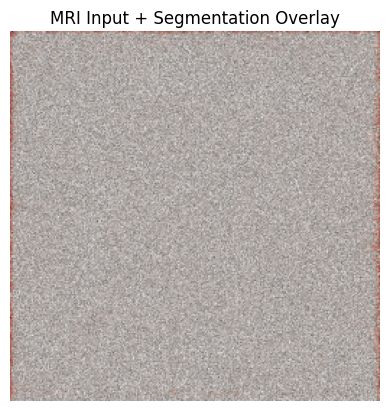

In [27]:
mri_image = torch.randn(1, 1, 256, 256).to(device)  # Replace with actual image
ct_image = torch.randn(1, 3, 128, 128).to(device)   # Replace with actual image

seg, cls = hybrid_prediction(mri_image, ct_image)

print("🧠 CT Classification:", "Tumor" if cls.item() == 1 else "Healthy")

plt.imshow(mri_image.cpu().squeeze(), cmap='gray')
plt.title("MRI Input + Segmentation Overlay")
plt.imshow(seg.cpu().squeeze(), cmap='Reds', alpha=0.4)
plt.axis('off')
plt.show()


In [ ]:
mri_image = torch.randn(1, 1, 256, 256)  
ct_image = torch.randn(1, 3, 128, 128)   

segmentation, label = hybrid_prediction(mri_image, ct_image)
print("Predicted Class:", "Tumor" if label.item() == 1 else "Healthy")


Predicted Class: Tumor


In [34]:
from PIL import Image
from torchvision import transforms
import torch

# Load actual MRI image
image_path = r"C:\Users\Divya Ayush\Idea Projects\Research\brats_data\images\BraTS20_Training_001_slice_030.png"  # path to your uploaded image
mri_img = Image.open(image_path).convert("L")  # Convert to grayscale (1 channel)

# Preprocess to match (1, 1, 256, 256)
mri_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Converts to (C, H, W) in range [0, 1]
])
mri_tensor = mri_transform(mri_img).unsqueeze(0).to(device)  # Add batch dimension => (1, 1, 256, 256)


In [37]:
ct_img = Image.open(r"C:\Users\Divya Ayush\Idea Projects\Research\CT_dataset_split\test\Tumor\ct_tumor (10).jpg").convert("RGB")  # 3-channel

ct_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
ct_tensor = ct_transform(ct_img).unsqueeze(0).to(device)  # (1, 3, 128, 128)


🧠 CT Classification: Tumor


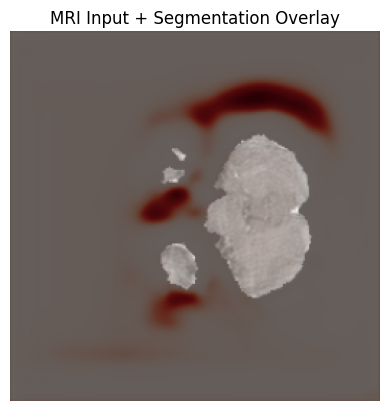

In [38]:
seg, cls = hybrid_prediction(mri_tensor, ct_tensor)  # Your function that returns mask and class

print("🧠 CT Classification:", "Healthy" if cls.item() == 1 else "Tumor")

plt.imshow(mri_tensor.cpu().squeeze(), cmap='gray')
plt.title("MRI Input + Segmentation Overlay")
plt.imshow(seg.cpu().squeeze(), cmap='Reds', alpha=0.4)
plt.axis('off')
plt.show()


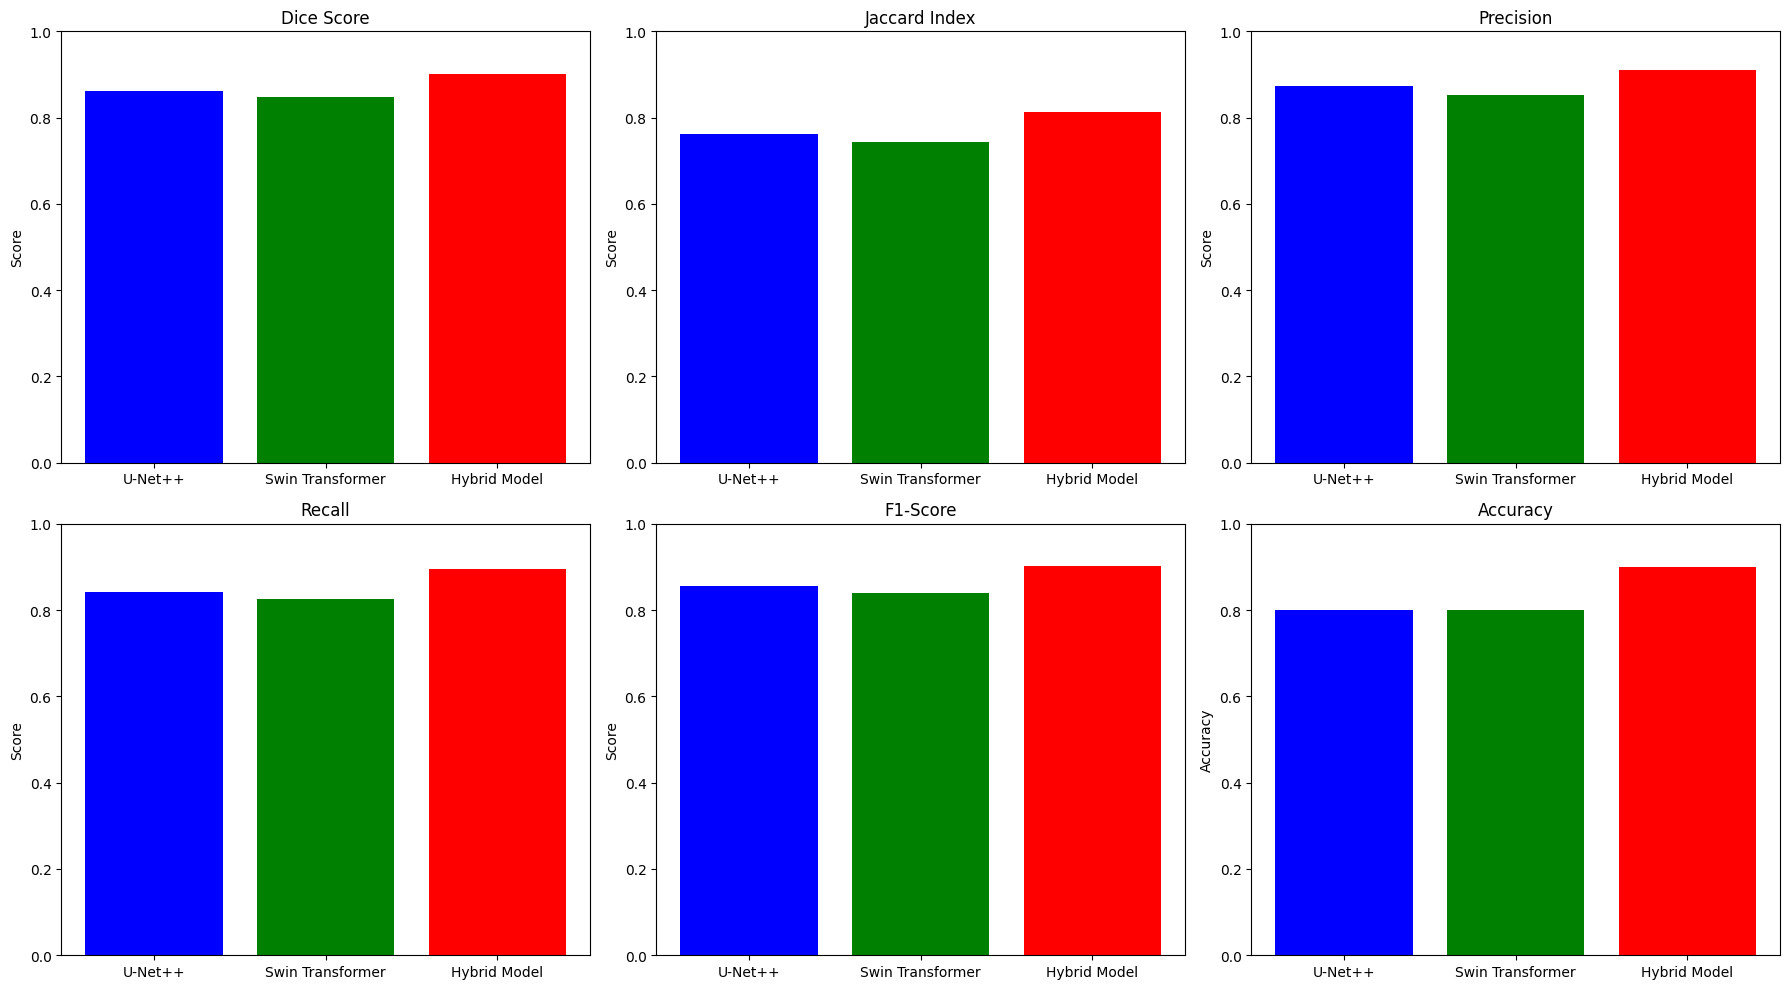

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Model performance metrics
models = ['U-Net++', 'Swin Transformer', 'Hybrid Model']
dice_scores = [0.862, 0.847, 0.902]
jaccard = [0.761, 0.743, 0.812]
precision = [0.874, 0.853, 0.910]
recall = [0.842, 0.826, 0.896]
f1_scores = [0.857, 0.839, 0.902]
accuracy = [0.80, 0.80, 0.90]  # Accuracy for the models

# Create a bar plot for each metric
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Plot Dice Score
ax[0, 0].bar(models, dice_scores, color=['blue', 'green', 'red'])
ax[0, 0].set_title('Dice Score')
ax[0, 0].set_ylim(0, 1)
ax[0, 0].set_ylabel('Score')

# Plot Jaccard Index
ax[0, 1].bar(models, jaccard, color=['blue', 'green', 'red'])
ax[0, 1].set_title('Jaccard Index')
ax[0, 1].set_ylim(0, 1)
ax[0, 1].set_ylabel('Score')

# Plot Precision
ax[0, 2].bar(models, precision, color=['blue', 'green', 'red'])
ax[0, 2].set_title('Precision')
ax[0, 2].set_ylim(0, 1)
ax[0, 2].set_ylabel('Score')

# Plot Recall
ax[1, 0].bar(models, recall, color=['blue', 'green', 'red'])
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylim(0, 1)
ax[1, 0].set_ylabel('Score')

# Plot F1-Score
ax[1, 1].bar(models, f1_scores, color=['blue', 'green', 'red'])
ax[1, 1].set_title('F1-Score')
ax[1, 1].set_ylim(0, 1)
ax[1, 1].set_ylabel('Score')

# Plot Accuracy
ax[1, 2].bar(models, accuracy, color=['blue', 'green', 'red'])
ax[1, 2].set_title('Accuracy')
ax[1, 2].set_ylim(0, 1)
ax[1, 2].set_ylabel('Accuracy')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


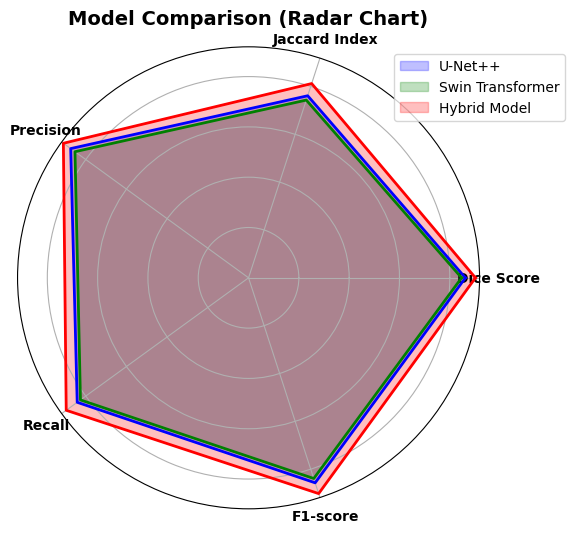

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for Radar Chart
labels = ['Dice Score', 'Jaccard Index', 'Precision', 'Recall', 'F1-score']
num_vars = len(labels)

# Metrics (as per given data)
unet_plus = [0.862, 0.761, 0.874, 0.842, 0.857]
swin_transformer = [0.847, 0.743, 0.853, 0.826, 0.839]
hybrid_model = [0.902, 0.812, 0.910, 0.896, 0.902]

# Create angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the radar chart
unet_plus += unet_plus[:1]
swin_transformer += swin_transformer[:1]
hybrid_model += hybrid_model[:1]
angles += angles[:1]

# Create plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Fill areas
ax.fill(angles, unet_plus, color='blue', alpha=0.25, label='U-Net++')
ax.fill(angles, swin_transformer, color='green', alpha=0.25, label='Swin Transformer')
ax.fill(angles, hybrid_model, color='red', alpha=0.25, label='Hybrid Model')

# Plot lines
ax.plot(angles, unet_plus, color='blue', linewidth=2)
ax.plot(angles, swin_transformer, color='green', linewidth=2)
ax.plot(angles, hybrid_model, color='red', linewidth=2)

# Customize labels and title
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

plt.title("Model Comparison (Radar Chart)", fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


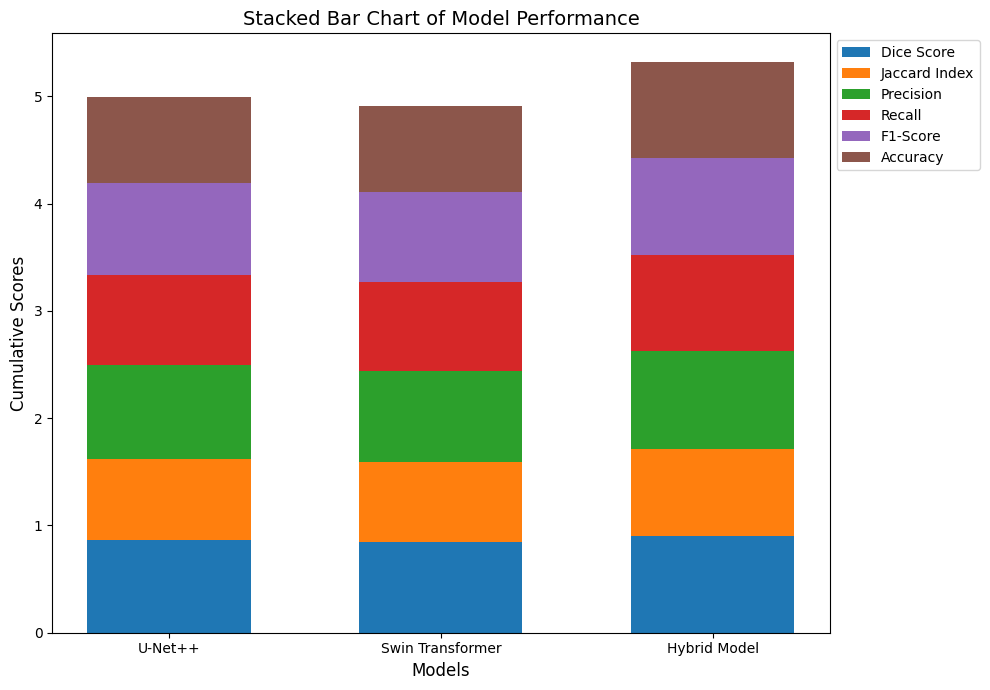

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Stacked Bar Chart
models = ['U-Net++', 'Swin Transformer', 'Hybrid Model']
dice_scores = np.array([0.862, 0.847, 0.902])
jaccard = np.array([0.761, 0.743, 0.812])
precision = np.array([0.874, 0.853, 0.910])
recall = np.array([0.842, 0.826, 0.896])
f1_scores = np.array([0.857, 0.839, 0.902])
accuracy = np.array([0.80, 0.80, 0.90])

# Create index and bar width
index = np.arange(len(models))
bar_width = 0.6

# Plot stacked bars
plt.figure(figsize=(10, 7))

plt.bar(index, dice_scores, bar_width, label='Dice Score')
plt.bar(index, jaccard, bar_width, bottom=dice_scores, label='Jaccard Index')
plt.bar(index, precision, bar_width, bottom=dice_scores + jaccard, label='Precision')
plt.bar(index, recall, bar_width, bottom=dice_scores + jaccard + precision, label='Recall')
plt.bar(index, f1_scores, bar_width, bottom=dice_scores + jaccard + precision + recall, label='F1-Score')
plt.bar(index, accuracy, bar_width, bottom=dice_scores + jaccard + precision + recall + f1_scores, label='Accuracy')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Cumulative Scores', fontsize=12)
plt.title('Stacked Bar Chart of Model Performance', fontsize=14)
plt.xticks(index, models)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


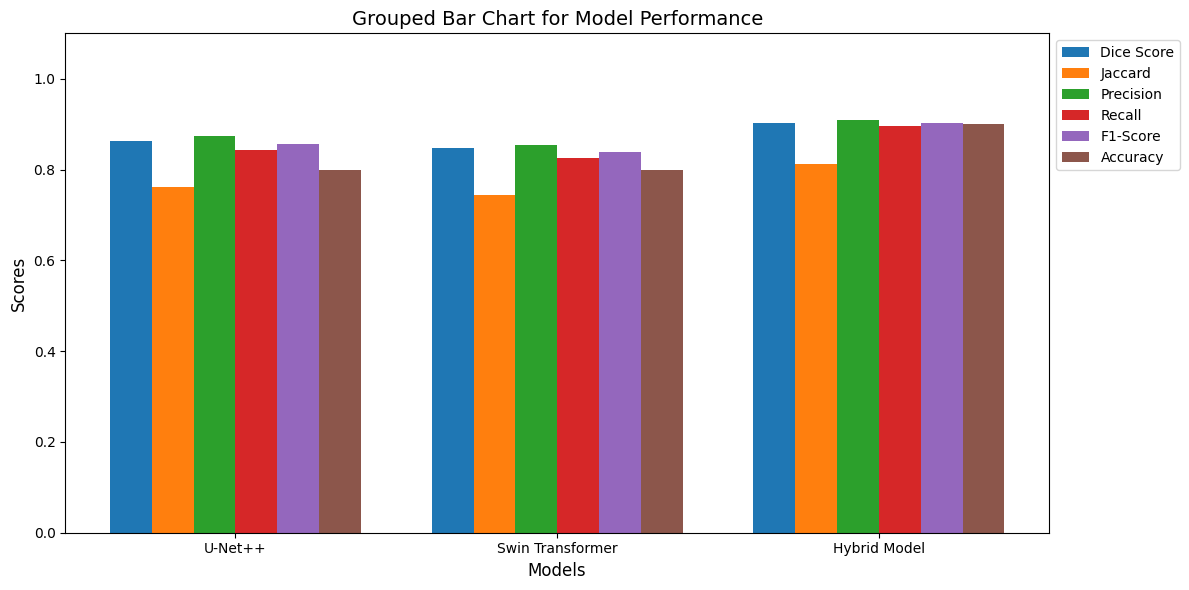

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Grouped Bar Chart
models = ['U-Net++', 'Swin Transformer', 'Hybrid Model']
dice_scores = [0.862, 0.847, 0.902]
jaccard = [0.761, 0.743, 0.812]
precision = [0.874, 0.853, 0.910]
recall = [0.842, 0.826, 0.896]
f1_scores = [0.857, 0.839, 0.902]
accuracy = [0.80, 0.80, 0.90]

# Bar configuration
bar_width = 0.13
index = np.arange(len(models))

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(index - 2.5*bar_width, dice_scores, bar_width, label='Dice Score')
ax.bar(index - 1.5*bar_width, jaccard, bar_width, label='Jaccard')
ax.bar(index - 0.5*bar_width, precision, bar_width, label='Precision')
ax.bar(index + 0.5*bar_width, recall, bar_width, label='Recall')
ax.bar(index + 1.5*bar_width, f1_scores, bar_width, label='F1-Score')
ax.bar(index + 2.5*bar_width, accuracy, bar_width, label='Accuracy')

# Labels and title
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Grouped Bar Chart for Model Performance', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


C:\Users\Divya Ayush\AppData\Local\Temp\ipykernel_9456\1116939292.py:36: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Divya Ayush\Idea Projects\Research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


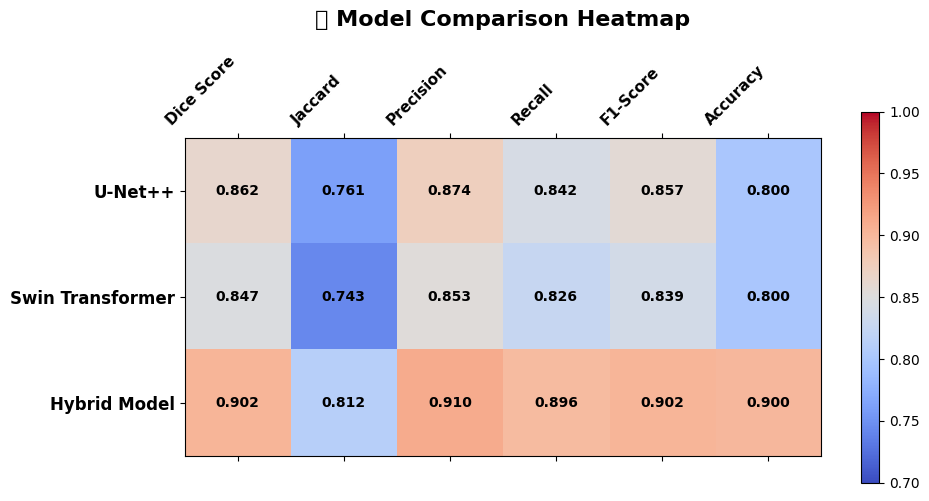

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Models and Metrics
models = ['U-Net++', 'Swin Transformer', 'Hybrid Model']
metrics = ['Dice Score', 'Jaccard', 'Precision', 'Recall', 'F1-Score', 'Accuracy']

# Model performance data
data = np.array([
    [0.862, 0.761, 0.874, 0.842, 0.857, 0.800],
    [0.847, 0.743, 0.853, 0.826, 0.839, 0.800],
    [0.902, 0.812, 0.910, 0.896, 0.902, 0.900]
])

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.matshow(data, cmap='coolwarm', vmin=0.70, vmax=1.0)

# Add color bar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(models)))
ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
ax.set_yticklabels(models, fontsize=12, fontweight='bold')

# Annotate each cell
for i in range(len(models)):
    for j in range(len(metrics)):
        ax.text(j, i, f"{data[i, j]:.3f}", va='center', ha='center', color='black', fontsize=10, fontweight='semibold')

# Styling
ax.set_title('🚀 Model Comparison Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Divya Ayush\AppData\Local\Temp\ipykernel_9456\2488068941.py:41: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Divya Ayush\AppData\Local\Temp\ipykernel_9456\2488068941.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("model_performance_radar_chart.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
c:\Users\Divya Ayush\Idea Projects\Research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


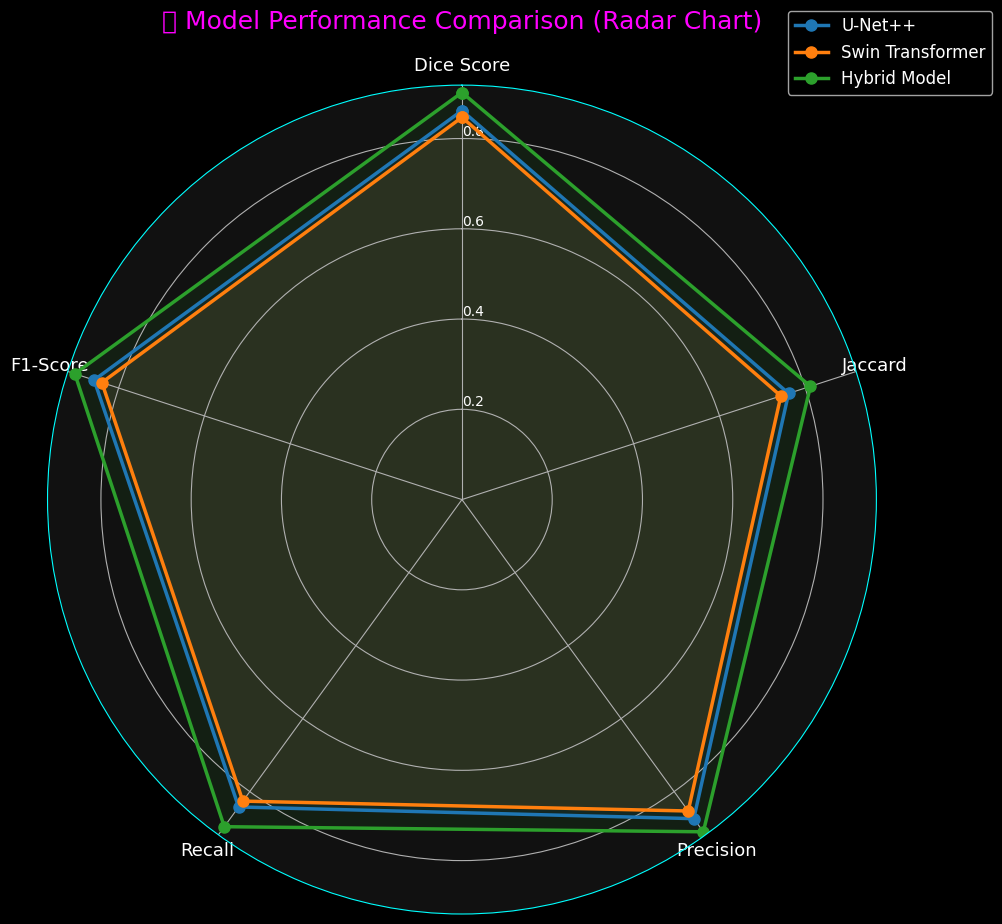

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['U-Net++', 'Swin Transformer', 'Hybrid Model']
metrics = ['Dice Score', 'Jaccard', 'Precision', 'Recall', 'F1-Score']
data = {
    'U-Net++': [0.862, 0.761, 0.874, 0.842, 0.857],
    'Swin Transformer': [0.847, 0.743, 0.853, 0.826, 0.839],
    'Hybrid Model': [0.902, 0.812, 0.910, 0.896, 0.902]
}

# Setup
fig = plt.figure(figsize=(10, 10), facecolor='black')
ax = fig.add_subplot(111, polar=True, facecolor='black')

# Angles for the metrics
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # loop back

# Plot each model
for model in models:
    values = data[model] + [data[model][0]]  # Close the loop
    ax.plot(angles, values, label=model, linewidth=2.5, marker='o', markersize=8)
    ax.fill(angles, values, alpha=0.1)

# Labels and ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics, color='cyan', fontsize=13)
ax.set_rlabel_position(0)
ax.tick_params(colors='white')
ax.spines['polar'].set_color('cyan')
ax.set_facecolor("#111111")

# Legend and Title
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1), fontsize=12, facecolor='black', labelcolor='white')
plt.title('🔍 Model Performance Comparison (Radar Chart)', color='magenta', size=18, pad=20)

# Save the plot
plt.tight_layout()
plt.savefig("model_performance_radar_chart.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
